In [ ]:
import numpy as np
import pandas as pd
import os

import torch
from torchvision import datasets, transforms

from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
dir_base= 'drive/My Drive/Colab Notebooks'
train_dir= dir_base + '/train'
test_dir= dir_base + '/test'

In [ ]:
categories= []
n_train= []
n_test= []

for num in os.listdir(train_dir):
    categories.append(num)
    
    train_img= os.listdir(train_dir + '/' + num)
    test_img= os.listdir(test_dir + '/' + num)
    
    n_train.append(len(train_img))
    n_test.append(len(test_img))
    
airlines= pd.DataFrame({'category': categories, 'n_train': n_train, 'n_test': n_test})
airlines.sort_values('n_train', ascending=False, inplace=True)
airlines[:10]

,category,n_train,n_test
8,aerflot,109,27
2,klm,107,30
4,aer lingus,105,24
6,air italy,105,30
5,air berlin,100,24
1,air canada,97,27
7,etihad,89,25
3,iberia,85,20
0,air france,84,24


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

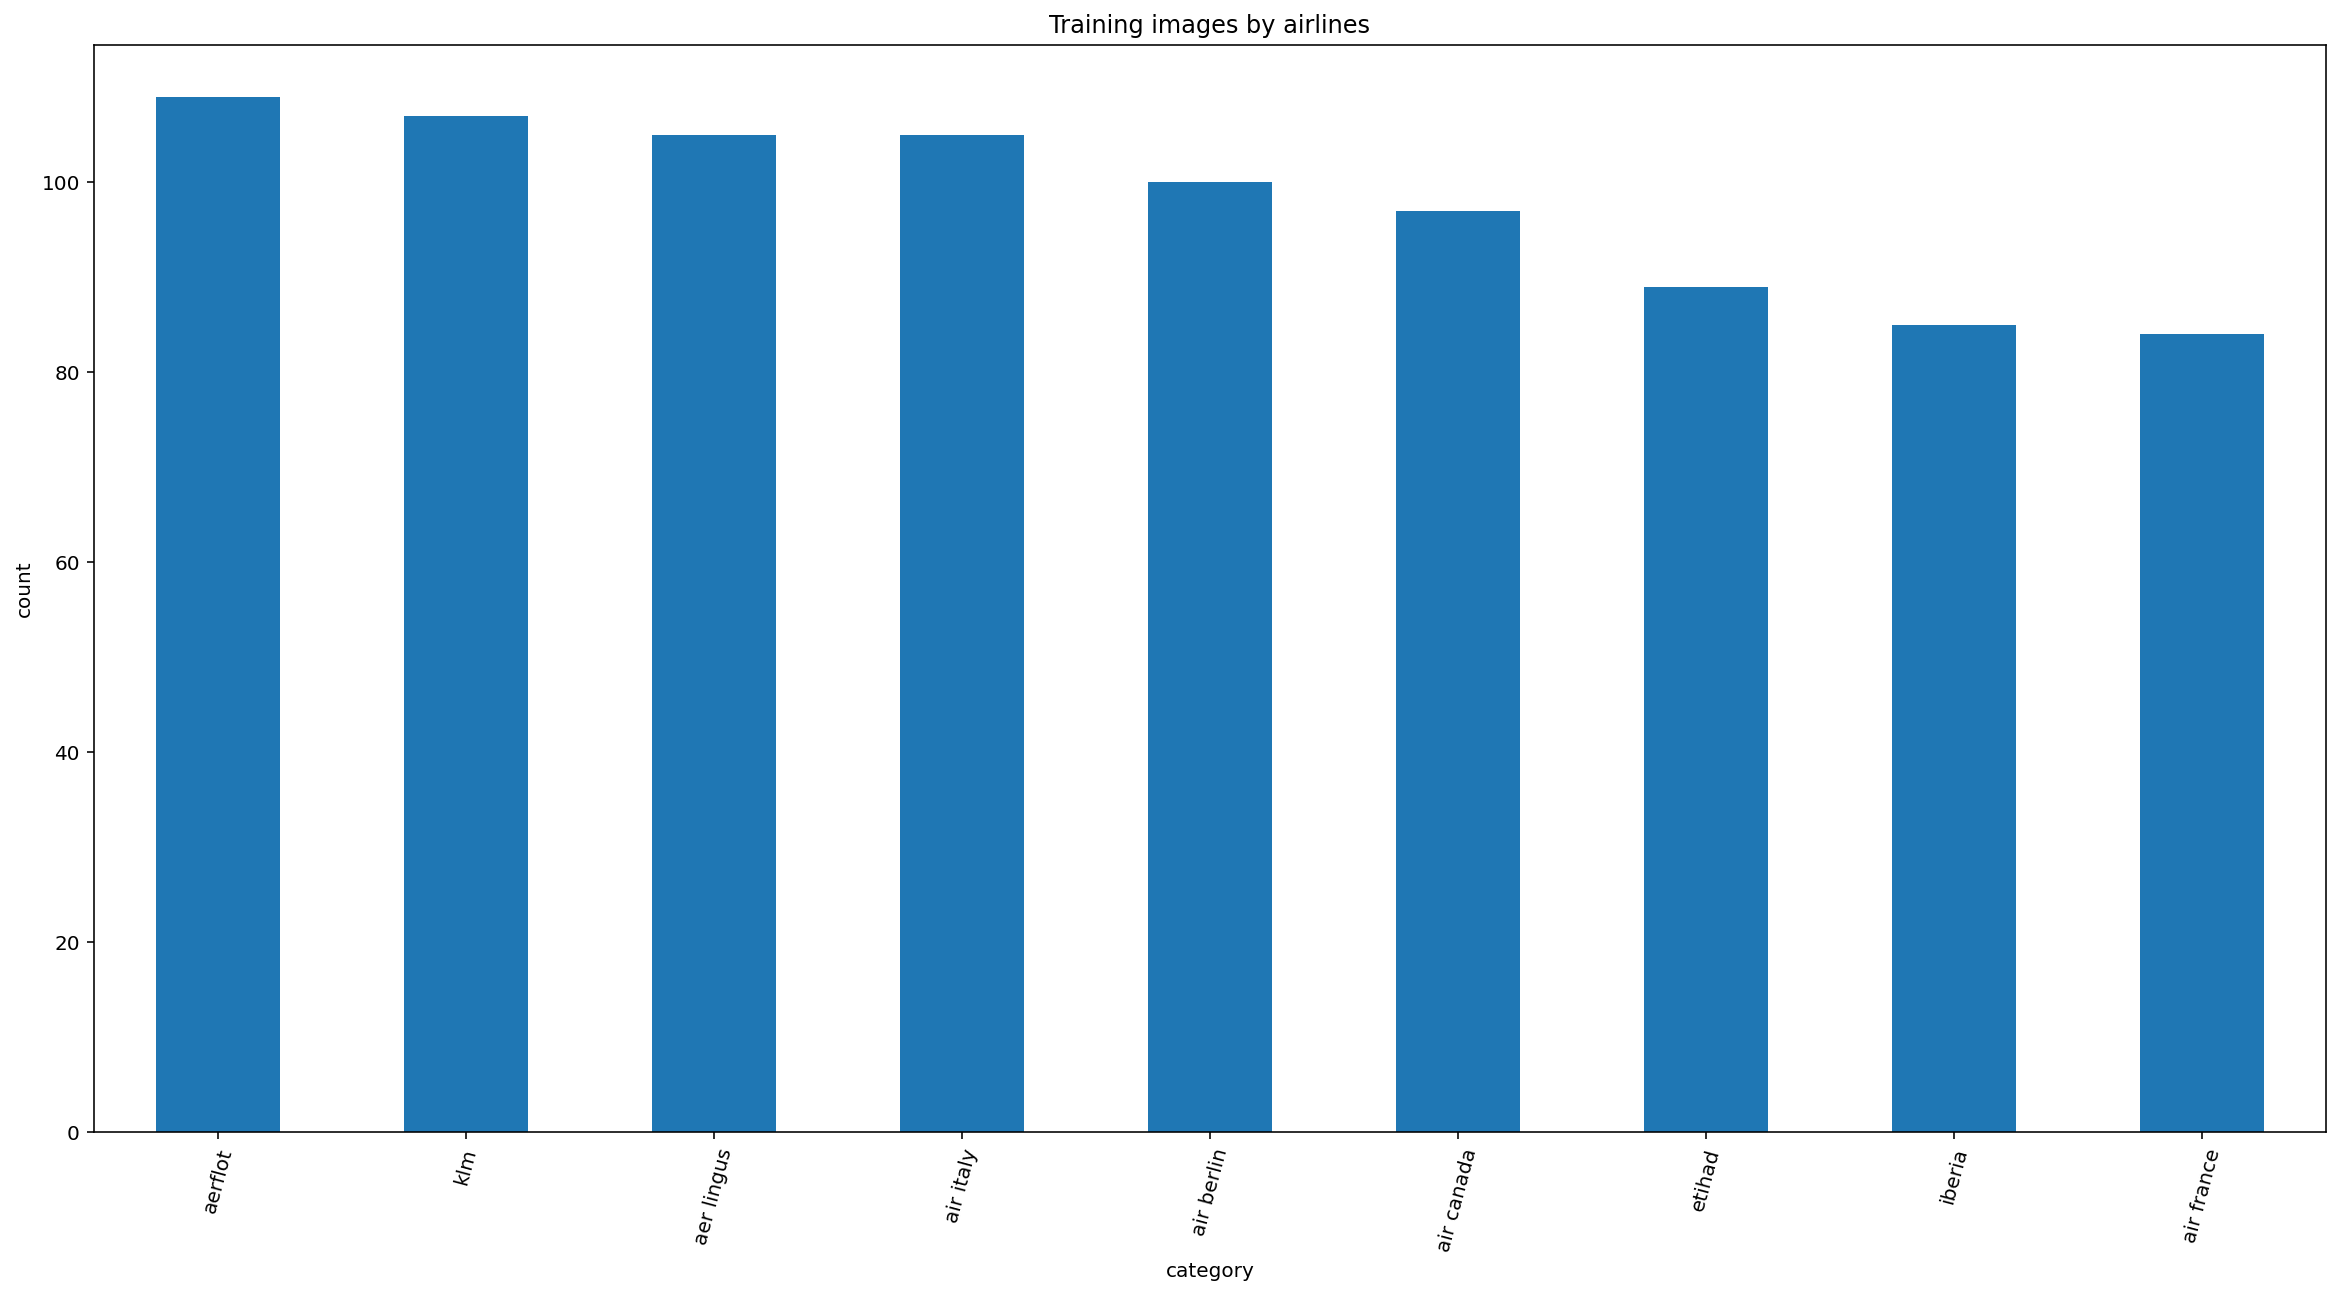

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Training images by airlines")
airlines.set_index('category')['n_train'].plot.bar()
plt.ylabel('count')
plt.xticks(rotation=75)

In [ ]:
# define transforms for training e test set

# DATA AUGMENTATION ONLY FOR TRAIN SET
train_tranforms= transforms.Compose([transforms.RandomRotation(45),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ColorJitter(),
                                     transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])

test_transforms= transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])
# load datasets
trainset= datasets.ImageFolder(train_dir, transform=train_tranforms )
testset= datasets.ImageFolder(test_dir, transform=test_transforms)

# define the dataloader
trainloader= torch.utils.data.DataLoader(trainset, batch_size= 64, shuffle=True)
testloader= torch.utils.data.DataLoader(testset, batch_size= 64) # batch_size is the number of images we get in one iteration
                                                                 # from the dataloader and pass trough the network

In [ ]:
import torchvision.models as models

images, labels= next(iter(trainloader))

print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 3, 224, 224])
torch.Size([64])


In [ ]:
# load in a model

model= models.densenet121(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
from torch import nn

# replace tha classifier
# freeze the parameters

for param in model.parameters():
    param.requires_grad= False
 
classifier= nn.Sequential(nn.Linear(1024, 500),
                               nn.ReLU(),
                               nn.Dropout(0.2),
                               nn.Linear(500, 102),
                               nn.ReLU(),
                               nn.Dropout(0.2),
                               nn.Linear(102, 9),
                               nn.LogSoftmax(dim=1))

model.classifier= classifier

In [ ]:
classifier

Sequential(
  (0): Linear(in_features=1024, out_features=500, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=500, out_features=102, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=102, out_features=9, bias=True)
  (7): LogSoftmax(dim=1)
)

In [ ]:
from torch import optim

# define the loss and the optimizer
criterion= nn.NLLLoss()
optimizer= optim.Adam(model.classifier.parameters(), lr=0.001)

In [ ]:
# train the model

n_epochs= 5
print_every= 2

results= []
steps= 0

for epoch in range(n_epochs):
  train_loss= 0
  test_loss= 0

  train_accuracy= 0
  test_accuracy= 0

  # set training
  model.train()

  for images, labels in trainloader:
    steps += 1

    optimizer.zero_grad()
    # get log probabilities from model
    logps= model(images)
    # get the loss
    loss= criterion(logps, labels)
    loss.backward()
    optimizer.step()
    # increment train loss 
    train_loss += loss.item()
            
    # calculate  train accuracy
    ps= torch.exp(logps)
    top_p, top_class= ps.topk(1, dim=1)
    equals= top_class == labels.view(*top_class.shape)
    train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    # after training loop end, start validation
    if steps % print_every == 0:
      with torch.no_grad():
        # set to evaluation mode
        model.eval() 

        for images, labels in testloader:
          logps= model(images)
          loss= criterion(logps, labels)
          # increment valid loss
          test_loss += loss.item()
                    
          # calculate validation accuracy
          ps= torch.exp(logps)
          top_p, top_class= ps.topk(1, dim=1)
          equals= top_class == labels.view(*top_class.shape)
          test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

          # average loss
          train_loss= train_loss/len(trainloader)
          test_loss= test_loss/len(testloader)
            
          # average accuracy
          train_accuracy= train_accuracy/len(trainloader)
          test_accuracy= test_accuracy/len(testloader)
            
    results.append([train_loss, test_loss, train_accuracy, test_accuracy])
            
    # print training and validation results
    if (epoch + 1) % print_every == 0:
      print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {test_loss:.4f}')
      print(f'\t\tTraining Accuracy: {100 * train_accuracy:.2f}%\t Validation Accuracy: {100 * test_accuracy:.2f}%')


   



# format results
results= pd.DataFrame(results, columns=['train_loss', 'test_loss', 'train_accuracy', 'test_accuracy'])







Epoch: 0 	Training Loss: 0.0001 	Validation Loss: 0.7334
		Training Accuracy: 0.00%	 Validation Accuracy: 0.15%

Epoch: 0 	Training Loss: 0.0001 	Validation Loss: 0.7474
		Training Accuracy: 0.00%	 Validation Accuracy: 0.15%

Epoch: 0 	Training Loss: 0.0001 	Validation Loss: 0.7265
		Training Accuracy: 0.00%	 Validation Accuracy: 0.15%

Epoch: 0 	Training Loss: 0.0001 	Validation Loss: 0.6957
		Training Accuracy: 0.00%	 Validation Accuracy: 0.15%

Epoch: 0 	Training Loss: 0.0001 	Validation Loss: 0.6830
		Training Accuracy: 0.00%	 Validation Accuracy: 17.23%

Epoch: 0 	Training Loss: 0.0001 	Validation Loss: 0.6841
		Training Accuracy: 0.00%	 Validation Accuracy: 15.68%

Epoch: 0 	Training Loss: 0.0001 	Validation Loss: 0.6880
		Training Accuracy: 0.00%	 Validation Accuracy: 14.41%

Epoch: 0 	Training Loss: 0.0001 	Validation Loss: 0.6969
		Training Accuracy: 0.00%	 Validation Accuracy: 8.06%

Epoch: 0 	Training Loss: 0.0001 	Validation Loss: 0.6976
		Training Accuracy: 0.00%	 Validat

KeyboardInterrupt: ignored